Install required packages

In [ ]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade opencv-python numpy pymodi tensorflow --user

Import packages

In [2]:
import numpy as np
import cv2
from IPython.display import display, Image, clear_output
import time
import modi

Running PyMODI (v0.9.1)


Define a necessary helper method

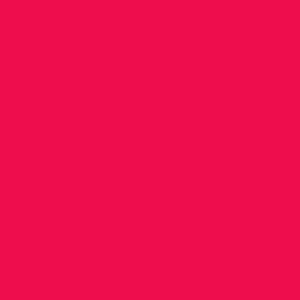

array([238,  13,  77])

In [3]:
def new_color():
    rgb = np.random.randint(0, 255, size=3)
    
    solid_color = np.zeros((300, 300, 3), np.uint8)
    solid_color[:] = rgb[::-1]
    _, ret = cv2.imencode('.png', solid_color)
    image = Image(data=ret)
    display(image)
    return rgb

new_color()

Intialize MODI object

In [4]:
bundle = modi.MODI()

env = bundle.envs[0]
led = bundle.leds[0]

Run Ser Task.
Start initializing connected MODI modules
Env (392) has been connected!
Led (3712) has been connected!


Generate data set

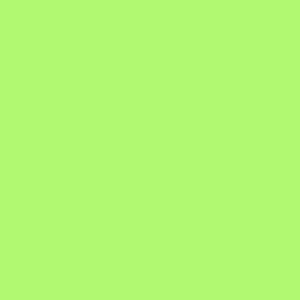

[22.69, 25.41, 18.46] -> [0.69019608 0.97647059 0.44313725]
[22.77, 25.43, 18.47] -> [0.69019608 0.97647059 0.44313725]
[22.94, 25.66, 18.58] -> [0.69019608 0.97647059 0.44313725]
[22.94, 25.89, 18.72] -> [0.69019608 0.97647059 0.44313725]
[23.59, 25.89, 18.72] -> [0.69019608 0.97647059 0.44313725]
[24.82, 26.85, 19.45] -> [0.69019608 0.97647059 0.44313725]
[24.82, 28.27, 20.51] -> [0.69019608 0.97647059 0.44313725]
[25.12, 28.62, 20.77] -> [0.69019608 0.97647059 0.44313725]
[25.13, 28.62, 20.77] -> [0.69019608 0.97647059 0.44313725]
[25.13, 28.65, 20.77] -> [0.69019608 0.97647059 0.44313725]


In [5]:
train_set = []
label_set = []

clear_output(wait=True)
new_color()
input("Place your env module on the color and press Enter when ready...")

for i in range(30):
    clear_output(wait=True)
    rgb = new_color()
    led.rgb = rgb // 5
    time.sleep(0.5)
    for i in range(10):
        label = rgb / 255
        data = [env.red, env.green, env.blue]
        label_set.append(label)
        train_set.append(data)
        print(f"{data} -> {label}")
        time.sleep(0.1)
    time.sleep(0.1)

train_set = np.array(train_set)
label_set = np.array(label_set)

Check out the generated dataset and save them to ./data

In [43]:
print(train_set.shape)
print(label_set.shape)

np.save('./data/label_set.npy', label_set, allow_pickle=True)
np.save('./data/train_set.npy', train_set, allow_pickle=True)

(300, 3)
(300, 3)


Training!!

In [ ]:
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense

train_set = np.load('./data/train_set.npy', allow_pickle=True)
label_set = np.load('./data/label_set.npy', allow_pickle=True)

shuffled_idx = np.random.permutation(train_set.shape[0])
split_idx = int(train_set.shape[0] * 0.8)
X_Train = train_set[shuffled_idx[:split_idx]]
y_Train = label_set[shuffled_idx[:split_idx]]
X_Test = train_set[shuffled_idx[split_idx:]]
y_Test = label_set[shuffled_idx[split_idx:]]

model = Sequential()
model.add(Dense(10, input_shape=(3,)))
model.add(Dense(10))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

EPOCH = 50
BATCH = 8
model.fit(X_Train, y_Train, epochs=EPOCH, batch_size=BATCH, verbose=1,
          validation_data=(X_Test, y_Test))

save_model(model, 'weights.h5')

Inference!!

In [ ]:
from tensorflow.keras.models import load_model
import time

model = load_model('weights.h5')

while True:
    clear_ouput(wait=True)
    rgb_read = np.array([env.red, env.green, env.blue])[np.newaxis, :]
    result = model.predict(rgb_read)[0] * 255 // 1
    color = np.zeros((300, 300, 3), np.uint8)
    color[:] = result[::-1]
    _, ret = cv2.imencode('.png', color)
    image = Image(data=ret)
    display(image)
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break
    led.rgb = result // 5